In [1]:
import urllib.request, urllib.parse, urllib.error
import numpy as np
import pandas as pd
pd.options.display.max_columns=50

#import PyQt5
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from datetime import datetime
import sys

from numpy.random import seed
seed(888)
import os

from sklearn.metrics import r2_score
from sklearn.metrics import  mean_absolute_error 
from catboost import CatBoostRegressor,Pool
import lightgbm as lgb

from scipy import stats
from scipy.cluster.vq import vq, kmeans, whiten

# !pip install wget
import wget

# !pip install missingno
import missingno as msno

import seaborn as sns

%matplotlib inline
# !pip install pandas_profiling


import holidays


In [2]:
# url = 'http://files.bidderstack.com/hackathon.zip'
# filename = wget.download(url)

In [3]:
# filename

In [4]:
# import shutil
# shutil.unpack_archive(filename,'/mnt/terabait/zipzip/')

In [5]:
df = pd.read_csv('/mnt/terabait/zipzip/train.csv')

In [6]:
df

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1
...,...,...,...,...,...,...,...,...,...,...
44854511,3,Games,Simulation,1068204657,2021-08-07 17:19:23,MSK,Краснодарский край,Краснодар,ios,14.4.2
44854512,3,Games,Puzzle,com.easybrain.nonogram.color,2021-08-02 09:17:16,MSK,Владимирская область,Владимир,android,11.0
44854513,5,Games,Arcade,com.nordcurrent.canteenhd,2021-09-16 09:26:38,MSK,Брянская область,Брянск,android,5.1
44854514,4,NaN,NaN,com.fugo.wow,2021-07-09 18:02:33,MSK,Татарстан,Казань,Android,7.1.2


In [7]:
display(
    df.info(),
    df.columns,
    df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44854516 entries, 0 to 44854515
Data columns (total 10 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Segment          int64 
 1   gamecategory     object
 2   subgamecategory  object
 3   bundle           object
 4   created          object
 5   shift            object
 6   oblast           object
 7   city             object
 8   os               object
 9   osv              object
dtypes: int64(1), object(9)
memory usage: 3.3+ GB


None

Index(['Segment', 'gamecategory', 'subgamecategory', 'bundle', 'created',
       'shift', 'oblast', 'city', 'os', 'osv'],
      dtype='object')

Segment                   0
gamecategory       16961331
subgamecategory    16968425
bundle                17284
created                   0
shift               3591150
oblast              3455278
city                4799992
os                      233
osv                     283
dtype: int64

In [8]:
df_train = df.iloc[500000:1000000]
df_train

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
500000,5,Games,Casual,art.color.planet.paint.by.number.game.puzzle.free,2021-08-02 13:38:52,MSK,Волгоградская область,Волгоград,android,8.1.0
500001,5,Applications,Tools,com.noxgroup.app.cleaner,2021-08-03 14:34:13,MSK,Воронежская область,Воронеж,android,9.0
500002,4,Games,Casual,com.toybrickcrush.casual.avidly,2021-07-11 08:23:06,MSK-1,Калининградская область,Калининград,android,9.0
500003,3,NaN,NaN,com.bandagames.mpuzzle.gp,2021-08-04 09:07:18,MSK,Москва,Москва,android,10.0.0
500004,3,Games,Puzzle,1117841866,2021-08-03 17:38:41,MSK+1,Самарская область,Самара,ios,12.5.4
...,...,...,...,...,...,...,...,...,...,...
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0


<AxesSubplot:>

<AxesSubplot:>

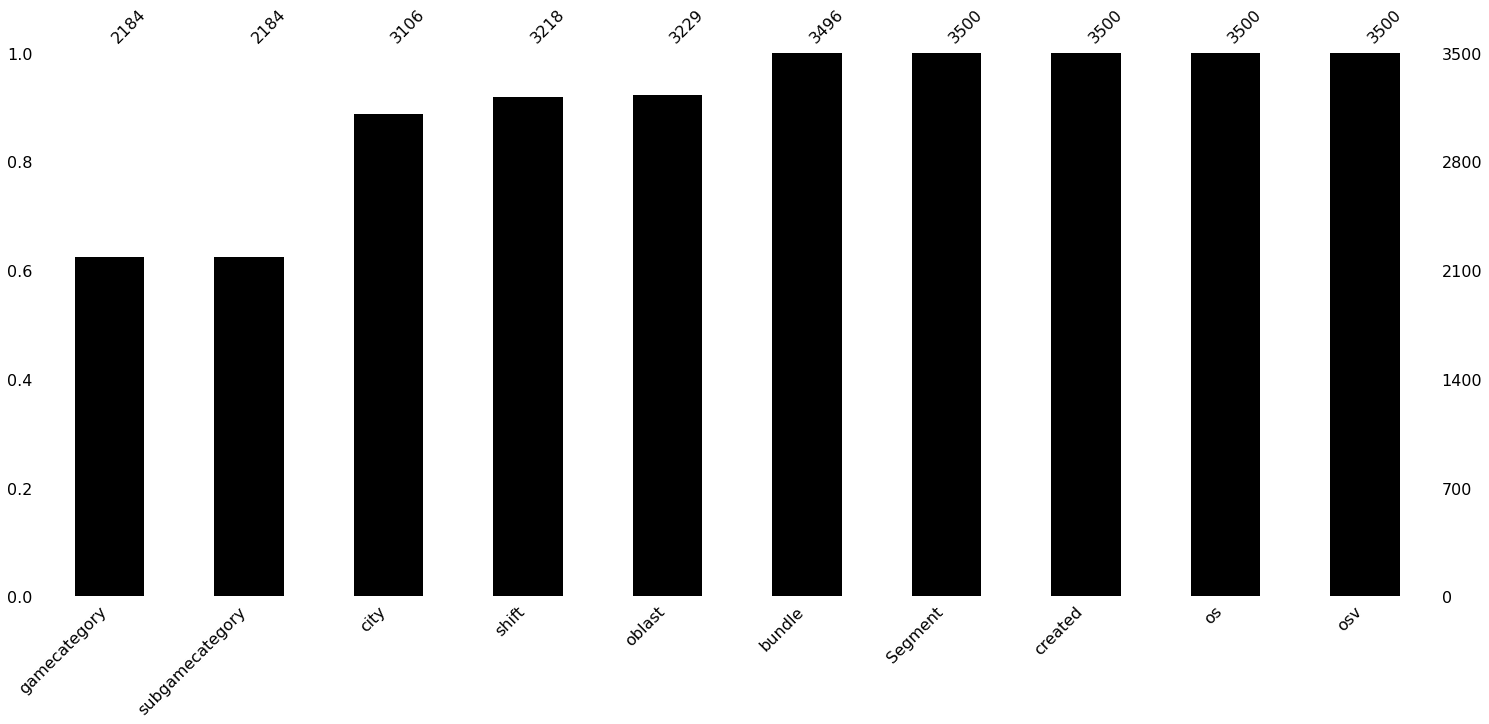

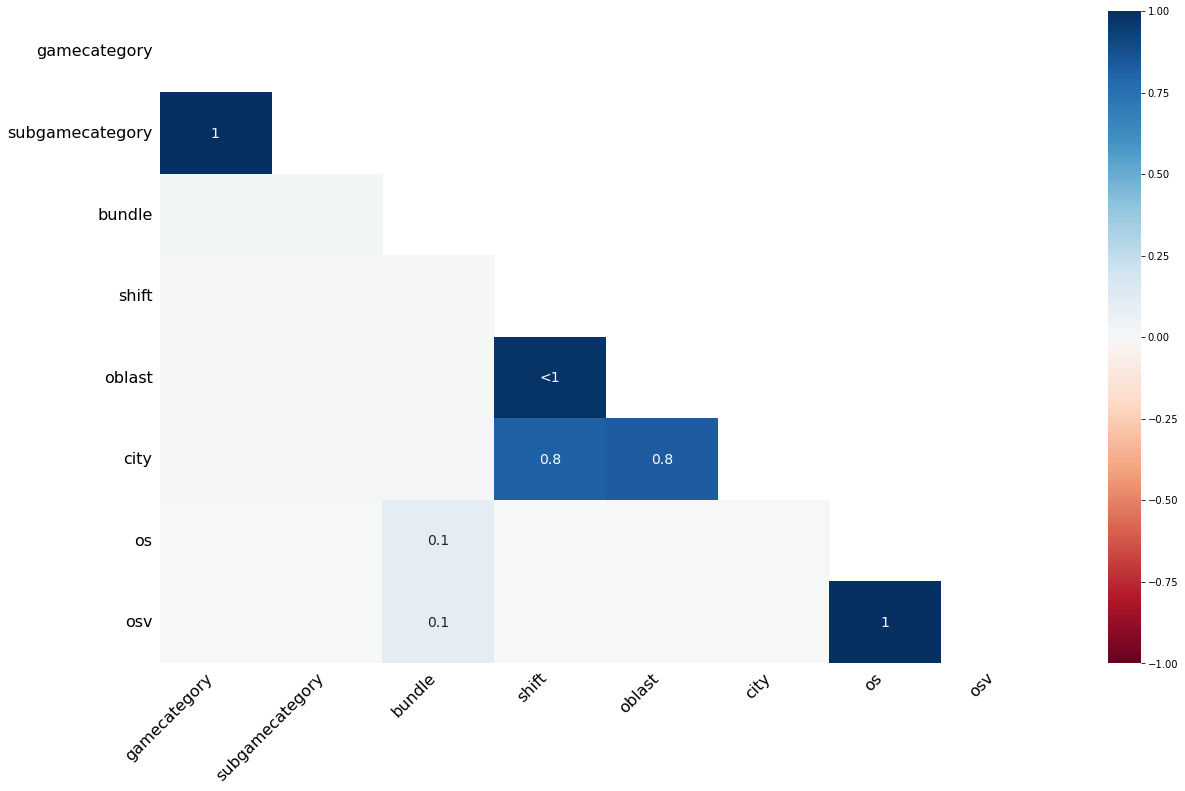

In [9]:
display(msno.bar(df_train.sample(3500),
                        color='black', 
                        sort = 'ascending',
                       ),
       msno.heatmap(df_train))

In [10]:
#  0   Segment          int64 
#  1   gamecategory     object
#  2   subgamecategory  object
#  3   bundle           object
#  4   created          object
#  5   shift            object
#  6   oblast           object
#  7   city             object
#  8   os               object
#  9   osv              object

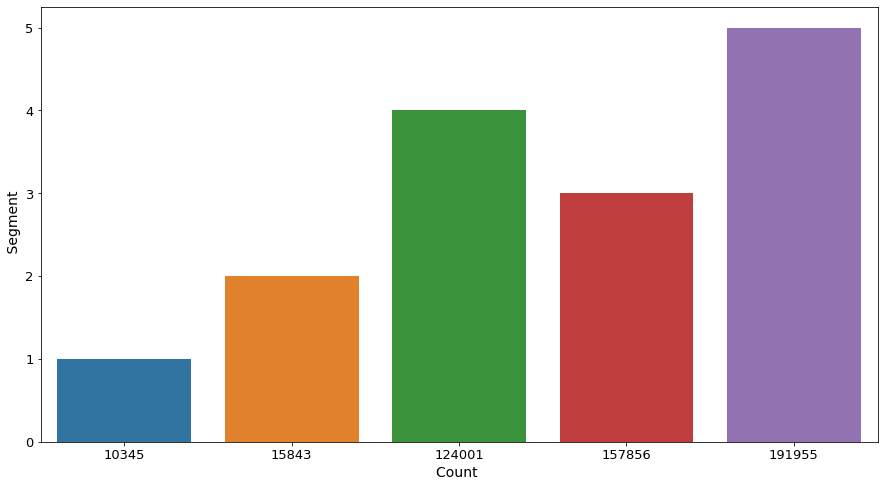

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_train['Segment'].value_counts().reset_index(),
        y='index',x='Segment')
plt.xticks(fontsize=13)
plt.xlabel("Count ",fontsize=14)
plt.yticks(fontsize=13)
plt.ylabel(" Segment",fontsize=14)
plt.show()

In [12]:
len(df_train.loc[(df_train['Segment']==5)].values)

191955

In [13]:
display(df_train.loc[(df_train['os']=='ios')].tail(20))

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
999820,3,Games,Action,556164350,2021-09-16 14:39:40,MSK,Санкт-Петербург,Санкт-Петербург,ios,14.4.1
999826,5,Games,Puzzle,1483058899,2021-09-18 23:38:51,MSK,Татарстан,Казань,ios,14.4.2
999830,4,NaN,NaN,1435758523,2021-07-06 14:31:06,MSK,Москва,Москва,ios,14.6.0
999838,5,Games,Word,1483222663,2021-09-20 13:53:24,NaN,NaN,NaN,ios,14.7.1
999851,3,Games,Simulation,1541751298,2021-07-05 09:51:53,MSK,Калужская область,Калуга,ios,14.6
999858,5,Games,Puzzle,1369521645,2021-09-16 16:19:38,NaN,NaN,NaN,ios,12.4.1
999861,5,Games,Puzzle,916281743,2021-08-03 14:04:56,MSK,Санкт-Петербург,Санкт-Петербург,ios,13.7
999862,3,NaN,NaN,1509517244,2021-09-17 10:35:57,MSK,Владимирская область,Муром,ios,12.5.4
999883,5,Games,Puzzle,1494648714,2021-08-03 11:27:16,MSK,Москва,Москва,ios,14.6
999918,3,Games,Role Playing,1300588558,2021-07-09 01:50:26,MSK+7,Приморский край,Владивосток,ios,14.6


In [14]:
df_train_shift = df_train.loc[(df_train['Segment']==5)]['shift']

In [22]:
df_train['created'].unique()

array(['2021-08-02 13:38:52', '2021-08-03 14:34:13',
       '2021-07-11 08:23:06', ..., '2021-08-08 15:49:54',
       '2021-07-07 21:05:47', '2021-09-20 10:36:34'], dtype=object)

In [17]:
set(df_train_shift)

{'MSK',
 'MSK+1',
 'MSK+2',
 'MSK+3',
 'MSK+4',
 'MSK+5',
 'MSK+6',
 'MSK+7',
 'MSK+8',
 'MSK+9',
 'MSK-1',
 nan}

In [18]:
from pandas_profiling import ProfileReport
profile_final = ProfileReport(df_train, explorative=True, minimal=False)
profile_final.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
df_train.columns

Index(['Segment', 'gamecategory', 'subgamecategory', 'bundle', 'created',
       'shift', 'oblast', 'city', 'os', 'osv'],
      dtype='object')

In [57]:
df_train_2 = df_train.copy(deep=True)


In [58]:
display(df_train_2.isna().sum(),
        df_train_2.info(),
       df_train_2.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 500000 to 999999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Segment          500000 non-null  int64 
 1   gamecategory     310802 non-null  object
 2   subgamecategory  310732 non-null  object
 3   bundle           499820 non-null  object
 4   created          500000 non-null  object
 5   shift            459920 non-null  object
 6   oblast           461435 non-null  object
 7   city             446505 non-null  object
 8   os               499998 non-null  object
 9   osv              499998 non-null  object
dtypes: int64(1), object(9)
memory usage: 38.1+ MB


Segment                 0
gamecategory       189198
subgamecategory    189268
bundle                180
created                 0
shift               40080
oblast              38565
city                53495
os                      2
osv                     2
dtype: int64

None

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0
999999,5,Games,Strategy,net.wargaming.wot.blitz,2021-08-03 09:07:40,MSK,Москва,Москва,android,7.0


In [59]:
display(df_train_2['created'].max(),
        df_train_2['created'].min()
       )

df_train_2.loc[(df_train_2['created']<'2021-01-10')]

'2021-09-20 23:58:22'

'1970-01-01 03:00:00'

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
826581,4,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN
835484,3,NaN,NaN,NaN,1970-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN


In [62]:
df_train_2 = df_train_2.loc[~(df_train_2['created']<='2021-01-01')]
df_train_2

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
500000,5,Games,Casual,art.color.planet.paint.by.number.game.puzzle.free,2021-08-02 13:38:52,MSK,Волгоградская область,Волгоград,android,8.1.0
500001,5,Applications,Tools,com.noxgroup.app.cleaner,2021-08-03 14:34:13,MSK,Воронежская область,Воронеж,android,9.0
500002,4,Games,Casual,com.toybrickcrush.casual.avidly,2021-07-11 08:23:06,MSK-1,Калининградская область,Калининград,android,9.0
500003,3,NaN,NaN,com.bandagames.mpuzzle.gp,2021-08-04 09:07:18,MSK,Москва,Москва,android,10.0.0
500004,3,Games,Puzzle,1117841866,2021-08-03 17:38:41,MSK+1,Самарская область,Самара,ios,12.5.4
...,...,...,...,...,...,...,...,...,...,...
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0


In [63]:

#
#ALERT
df_train_2['created'] = df_train_2['created'].fillna(method='ffill')
#ALERT
#

df_train_2['created'] = pd.to_datetime(df_train_2['created'], format = '%Y-%m-%d %H:%M:%S')
df_train_2['year'] = df_train_2['created'].dt.year
df_train_2['month'] = df_train_2['created'].dt.month
df_train_2['day'] = df_train_2['created'].dt.day
df_train_2['hour'] = df_train_2['created'].dt.hour
df_train_2['minute'] = df_train_2['created'].dt.minute


df_train_2

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,year,month,day,hour,minute
500000,5,Games,Casual,art.color.planet.paint.by.number.game.puzzle.free,2021-08-02 13:38:52,MSK,Волгоградская область,Волгоград,android,8.1.0,2021,8,2,13,38
500001,5,Applications,Tools,com.noxgroup.app.cleaner,2021-08-03 14:34:13,MSK,Воронежская область,Воронеж,android,9.0,2021,8,3,14,34
500002,4,Games,Casual,com.toybrickcrush.casual.avidly,2021-07-11 08:23:06,MSK-1,Калининградская область,Калининград,android,9.0,2021,7,11,8,23
500003,3,NaN,NaN,com.bandagames.mpuzzle.gp,2021-08-04 09:07:18,MSK,Москва,Москва,android,10.0.0,2021,8,4,9,7
500004,3,Games,Puzzle,1117841866,2021-08-03 17:38:41,MSK+1,Самарская область,Самара,ios,12.5.4,2021,8,3,17,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0,2021,7,7,21,5
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0,2021,9,20,10,36
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0,2021,8,3,12,24
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0,2021,8,3,13,47


In [64]:
NON_WORK_DAY_DICT = {
    2021: {
        1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 23, 24, 30, 31],
        2: [6, 7, 13, 14, 21, 22, 23, 27, 28],
        3: [6, 7, 8, 13, 14, 20, 21, 27, 28],
        4: [3, 4, 10, 11, 17, 18, 24, 25],
        5: [1, 2, 3, 8, 9, 10, 15, 16, 22, 23, 29, 30],
        6: [5, 6, 12, 13, 14, 19, 20, 26, 27],
        7: [3, 4, 10, 11, 17, 18, 24, 25, 31],
        8: [1, 7, 8, 14, 15, 21, 22, 28, 29],
        9: [4, 5, 11, 12, 18, 19, 25, 26],
        10: [2, 3, 9, 10, 16, 17, 23, 24, 30, 31],
        11: [4, 5, 6, 7, 13, 14, 20, 21, 27, 28],
        12: [4, 5, 11, 12, 18, 19, 25, 26, 31]
    },
    2022: {
        1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 22, 23, 29, 30],
        2: [5, 6, 12, 13, 19, 20, 23, 26, 27],
        3: [6, 7, 8, 12, 13, 19, 20, 26, 27],
        4: [2, 3, 9, 10, 16, 17, 23, 24, 30],
        5: [1, 2, 3, 7, 8, 9, 10, 14, 15, 21, 22, 28, 29],
        6: [4, 5, 11, 12, 13, 18, 19, 25, 26],
        7: [2, 3, 9, 10, 16, 17, 23, 24, 30, 31],
        8: [6, 7, 13, 14, 20, 21, 27, 28],
        9: [3, 4, 10, 11, 17, 18, 24, 25],
        10: [1, 2, 8, 9, 15, 16, 22, 23, 29, 30],
        11: [4, 5, 6, 12, 13, 19, 20, 26, 27],
        12: [3, 4, 10, 11, 17, 18, 24, 25, 31]
    }
}


In [65]:
df_train_2['is_working'] = 0

for i in df_train_2.index:
    if not df_train_2['day'].loc[i] in NON_WORK_DAY_DICT[df_train_2['year'].loc[i]][df_train_2['month'].loc[i]]:
        df_train_2['is_working'].loc[i] = 1

df_train_2

/home/zodiac180/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,year,month,day,hour,minute,is_working
500000,5,Games,Casual,art.color.planet.paint.by.number.game.puzzle.free,2021-08-02 13:38:52,MSK,Волгоградская область,Волгоград,android,8.1.0,2021,8,2,13,38,1
500001,5,Applications,Tools,com.noxgroup.app.cleaner,2021-08-03 14:34:13,MSK,Воронежская область,Воронеж,android,9.0,2021,8,3,14,34,1
500002,4,Games,Casual,com.toybrickcrush.casual.avidly,2021-07-11 08:23:06,MSK-1,Калининградская область,Калининград,android,9.0,2021,7,11,8,23,0
500003,3,NaN,NaN,com.bandagames.mpuzzle.gp,2021-08-04 09:07:18,MSK,Москва,Москва,android,10.0.0,2021,8,4,9,7,1
500004,3,Games,Puzzle,1117841866,2021-08-03 17:38:41,MSK+1,Самарская область,Самара,ios,12.5.4,2021,8,3,17,38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0,2021,7,7,21,5,1
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0,2021,9,20,10,36,1
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0,2021,8,3,12,24,1
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0,2021,8,3,13,47,1


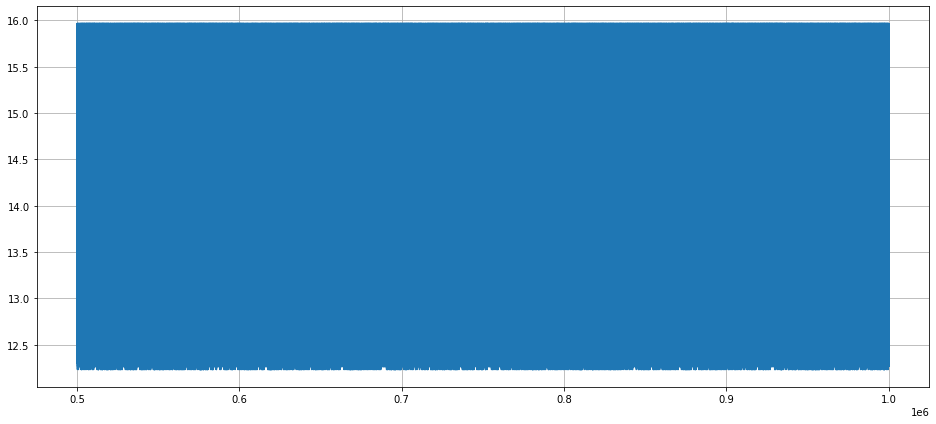

In [69]:
import ephem,datetime

sun = ephem.Sun()
moon = ephem.Moon()
raleigh = ephem.Observer()
#raleigh.lon, raleigh.lat = "86.10426", "55.4467" #kem


raleigh.lon, raleigh.lat = "134.973", "48.4649" #хабар


raleigh.horizon = '-0:34'  # USNO standard atmospheric diffraction
raleigh.pressure = 0       # atmospheric refraction parameters

def riseset_sun(date, f):
    raleigh.date = date
    sun.compute(raleigh)
    sr = ephem.localtime(f(sun))    
    return sr

def riseset_moon(date, f):
    raleigh.date = date
    moon.compute(raleigh)
    sr = ephem.localtime(f(moon))    
    return sr



def sunframe(df):
    #Солнце
    df['sunrise'] = df['created'].map(lambda d: riseset_sun(d, raleigh.next_rising)) #+ np.timedelta64(7, 'h')
    df['sunset'] = df['created'].map(lambda d: riseset_sun(d, raleigh.next_setting)) #+ np.timedelta64(7, 'h')
    
    df['sunrise_h']=df['sunrise'].dt.hour
    df['sunrise_m']=df['sunrise'].dt.minute/60
    
    df['sunset_h']=df['sunset'].dt.hour      
    df['sunset_m']=df['sunset'].dt.minute/60

    
    df['Dsun']=(df['sunset_h'] + df['sunset_m'])-(df['sunrise_h'] + df['sunrise_m'])
    df['sunrise']=df['sunset_h'] + df['sunset_m']
    df['sunset'] =df['sunrise_h'] + df['sunrise_m']
    

    #луна 5-10% к точности
    df['sunrise_moon'] = df['created'].map(lambda d: riseset_moon(d, raleigh.next_rising)) #+ np.timedelta64(7, 'h')
    df['sunset_moon'] = df['created'].map(lambda d: riseset_moon(d, raleigh.next_setting)) #+ np.timedelta64(7, 'h')

    df['sunrise_moon_h']=df['sunrise_moon'].dt.hour
    df['sunrise_moon_m']=df['sunrise_moon'].dt.minute/60
    
    df['sunset_moon_h']=df['sunset_moon'].dt.hour      
    df['sunset_moon_m']=df['sunset_moon'].dt.minute/60
    
    df['sunrise_moon']=df['sunrise_moon_h']+df['sunrise_moon_m']
    df['sunset_moon']=df['sunset_moon_h']+df['sunset_moon_m']
    
    df['Dmoon']=df['sunset_moon']-df['sunrise_moon']
    
    
    
    return df

df_train_2 = sunframe(df_train_2)
df_train_2['Dsun'].plot(figsize=(16,7)).grid()


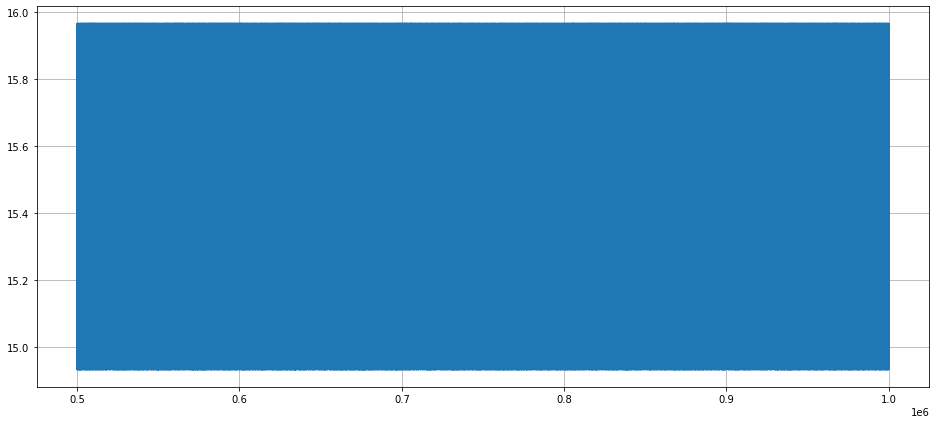

In [71]:
df_train_2.loc[(df_train_2['created'])<='2021-08-03']['Dsun'].plot(figsize=(16,7)).grid()

In [72]:
df_train_2

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,year,month,day,hour,minute,is_working,sunrise,sunset,sunrise_h,sunrise_m,sunset_h,sunset_m,Dsun,sunrise_moon,sunset_moon,sunrise_moon_h,sunrise_moon_m,sunset_moon_h,sunset_moon_m,Dmoon
500000,5,Games,Casual,art.color.planet.paint.by.number.game.puzzle.free,2021-08-02 13:38:52,MSK,Волгоградская область,Волгоград,android,8.1.0,2021,8,2,13,38,1,17.566667,2.616667,2,0.616667,17,0.566667,14.950000,21.666667,13.616667,21,0.666667,13,0.616667,-8.050000
500001,5,Applications,Tools,com.noxgroup.app.cleaner,2021-08-03 14:34:13,MSK,Воронежская область,Воронеж,android,9.0,2021,8,3,14,34,1,17.550000,2.633333,2,0.633333,17,0.550000,14.916667,22.166667,14.683333,22,0.166667,14,0.683333,-7.483333
500002,4,Games,Casual,com.toybrickcrush.casual.avidly,2021-07-11 08:23:06,MSK-1,Калининградская область,Калининград,android,9.0,2021,7,11,8,23,0,18.000000,2.183333,2,0.183333,18,0.000000,15.816667,3.850000,19.216667,3,0.850000,19,0.216667,15.366667
500003,3,NaN,NaN,com.bandagames.mpuzzle.gp,2021-08-04 09:07:18,MSK,Москва,Москва,android,10.0.0,2021,8,4,9,7,1,17.550000,2.650000,2,0.650000,17,0.550000,14.900000,22.783333,15.650000,22,0.783333,15,0.650000,-7.133333
500004,3,Games,Puzzle,1117841866,2021-08-03 17:38:41,MSK+1,Самарская область,Самара,ios,12.5.4,2021,8,3,17,38,1,17.550000,2.633333,2,0.633333,17,0.550000,14.916667,22.783333,14.683333,22,0.783333,14,0.683333,-8.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,NaN,NaN,com.ketchapp.rider,2021-07-07 21:05:47,MSK,Краснодарский край,Туапсе,android,9.0,2021,7,7,21,5,1,18.033333,2.133333,2,0.133333,18,0.033333,15.900000,0.866667,16.850000,0,0.866667,16,0.850000,15.983333
999996,5,Games,Puzzle,com.sg.colorsortpuzzle,2021-09-20 10:36:34,MSK+4,Кемеровская область,NaN,android,10.0,2021,9,20,10,36,1,16.000000,3.733333,3,0.733333,16,0.000000,12.266667,16.500000,3.450000,16,0.500000,3,0.450000,-13.050000
999997,4,NaN,NaN,love.journey.episode.luv,2021-08-03 12:24:08,NaN,NaN,NaN,android,11.0.0,2021,8,3,12,24,1,17.550000,2.633333,2,0.633333,17,0.550000,14.916667,22.166667,14.683333,22,0.166667,14,0.683333,-7.483333
999998,5,Games,Action,com.Upperpik.HairChallenge,2021-08-03 13:47:21,MSK,Московская область,Томилино,android,10.0,2021,8,3,13,47,1,17.550000,2.633333,2,0.633333,17,0.550000,14.916667,22.166667,14.683333,22,0.166667,14,0.683333,-7.483333


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,len(df_train_2.columns)):
    
    df_train_2[(df_train_2.columns[i])] = le.fit_transform(df_train_2[[(df_train_2.columns[i])]].astype(str))
#может, apply???
#tqdm contrib???????########

In [ ]:
df_train_2